<a href="https://colab.research.google.com/github/NguyenThiMyDuyen129/DoAn_TriTueNhanTao/blob/main/KMeans_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<font face="Times New Roman">
<font size="4.5">
<center>
<b>BÁO CÁO MÔN HỌC TRÍ TUỆ NHÂN TẠO</b><br>
</center>
<center>
<b>
HỌC MÁY
</b>
</center>
</font>

<p align="center">
<b>Sinh viên thực hiện:</b> Nguyễn Thị Mỹ Duyên - 2001230129
</font>

---
<font face="Times New Roman">
<center>
<b>CHƯƠNG 1: CƠ SỞ LÝ THUYẾT KMEANS</b>
</center>

---
<p>
<div align="justify">
<b>1.1. Giới thiệu KMeans</b><br>
&emsp;&emsp;K-means là một thuật toán phân cụm đơn giản thuộc loại học không giám sát(tức là dữ liệu không có nhãn) và được sử dụng để giải quyết bài toán phân cụm. Ý tưởng của thuật toán phân cụm k-means là phân chia 1 bộ dữ liệu thành các cụm khác nhau. Trong đó số lượng cụm được cho trước là k. Công việc phân cụm được xác lập dựa trên nguyên lý: Các điểm dữ liệu trong cùng 1 cụm thì phải có cùng 1 số tính chất nhất định. Tức là giữa các điểm trong cùng 1 cụm phải có sự liên quan lẫn nhau. Đối với máy tính thì các điểm trong 1 cụm đó sẽ là các điểm dữ liệu gần nhau.<br>
&emsp;&emsp;Thuật toán phân cụm k-means thường được sử dụng trong các ứng dụng cỗ máy tìm kiếm, phân đoạn khách hàng, thống kê dữ liệu,…<br>
</font>

In [4]:
# Import các thư viện cần thiết
import numpy as np  # Thư viện xử lý mảng và tính toán số học
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị và hiển thị dữ liệu
from scipy.spatial.distance import cdist  # Hàm tính khoảng cách giữa các điểm (dùng để tính khoảng cách từ điểm đến tâm cụm)

In [5]:
# Tạo dữ liệu mẫu để test thuật toán K-means
# means: Tọa độ trung tâm của 3 cụm dữ liệu (mỗi cụm có một điểm trung tâm)
means = [[2, 2], [9, 2], [4, 9]]

# cov: Ma trận hiệp phương sai (covariance matrix) - xác định hình dạng phân phối
# Ma trận [[2, 0], [0, 2]] có nghĩa là phương sai theo trục x và y đều là 2, không có tương quan
cov = [[2, 0], [0, 2]]

# n_samples: Số lượng điểm dữ liệu được tạo cho mỗi cụm
n_samples = 500

# n_cluster: Số lượng cụm (clusters) mà ta muốn phân chia dữ liệu
n_cluster = 3

# Tạo dữ liệu cho cụm 1: 500 điểm phân phối chuẩn quanh tâm (2, 2)
X0 = np.random.multivariate_normal(means[0], cov, n_samples)

# Tạo dữ liệu cho cụm 2: 500 điểm phân phối chuẩn quanh tâm (9, 2)
X1 = np.random.multivariate_normal(means[1], cov, n_samples)

# Tạo dữ liệu cho cụm 3: 500 điểm phân phối chuẩn quanh tâm (4, 9)
X2 = np.random.multivariate_normal(means[2], cov, n_samples)

# Ghép tất cả dữ liệu từ 3 cụm thành một mảng duy nhất X (tổng cộng 1500 điểm)
# axis=0: ghép theo chiều dọc (thêm các hàng mới)
X = np.concatenate((X0, X1, X2), axis=0)

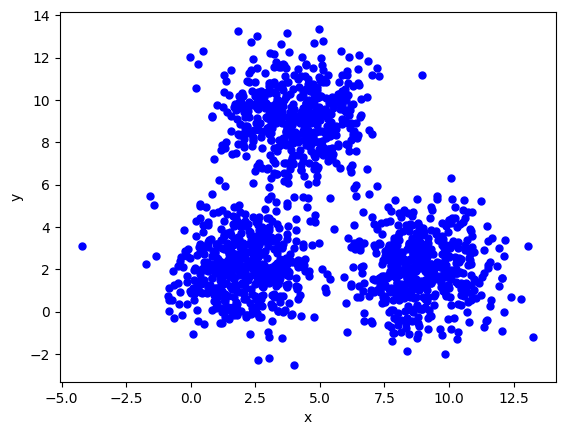

In [6]:
# Vẽ đồ thị để hiển thị dữ liệu ban đầu trước khi phân cụm
plt.xlabel("x")  # Đặt nhãn cho trục x
plt.ylabel("y")  # Đặt nhãn cho trục y

# Vẽ tất cả các điểm dữ liệu
# X[:, 0]: tọa độ x của tất cả các điểm
# X[:, 1]: tọa độ y của tất cả các điểm
# "bo": màu xanh (blue) với marker hình tròn (o)
# markersize=5: kích thước của marker
plt.plot(X[:, 0], X[:, 1], "bo", markersize=5)

plt.plot()  # Gọi hàm plot (có thể không cần thiết)
plt.show()  # Hiển thị đồ thị

In [7]:
# Hàm khởi tạo các tâm cụm ban đầu (centroids) một cách ngẫu nhiên
def kmeans_init_centers(X, n_cluster):
  # X: mảng dữ liệu đầu vào (mỗi hàng là một điểm dữ liệu)
  # n_cluster: số lượng cụm cần tạo

  # np.random.choice: chọn ngẫu nhiên n_cluster chỉ số từ 0 đến X.shape[0]-1
  # X.shape[0]: số lượng điểm dữ liệu
  # replace=False: không cho phép chọn trùng (mỗi điểm chỉ được chọn một lần)
  # Kết quả: trả về n_cluster điểm dữ liệu ngẫu nhiên làm tâm cụm ban đầu
  return X[np.random.choice(X.shape[0], n_cluster, replace=False)]

In [8]:
# Hàm gán nhãn (label) cho mỗi điểm dữ liệu dựa trên khoảng cách đến các tâm cụm
def kmeans_predict_labels(X, centers):
  # X: mảng dữ liệu đầu vào
  # centers: mảng chứa tọa độ của các tâm cụm

  # cdist: tính khoảng cách giữa mỗi điểm trong X và mỗi tâm cụm trong centers
  # Kết quả D là ma trận có kích thước (số điểm dữ liệu x số cụm)
  # D[i, j] = khoảng cách từ điểm thứ i đến tâm cụm thứ j
  D = cdist(X, centers)

  # np.argmin(D, axis=1): tìm chỉ số của tâm cụm gần nhất cho mỗi điểm
  # axis=1: tìm min theo từng hàng (mỗi hàng là một điểm dữ liệu)
  # Kết quả: mảng labels, labels[i] = chỉ số cụm mà điểm thứ i thuộc về
  return np.argmin(D, axis=1)

In [9]:
# Hàm cập nhật vị trí của các tâm cụm dựa trên các điểm đã được gán nhãn
def kmeans_update_center(X, labels, n_cluster):
  # X: mảng dữ liệu đầu vào
  # labels: mảng nhãn, labels[i] cho biết điểm thứ i thuộc cụm nào
  # n_cluster: số lượng cụm

  # Khởi tạo mảng centers với kích thước (n_cluster x số chiều dữ liệu)
  # X.shape[1]: số chiều của dữ liệu (trong trường hợp này là 2: x và y)
  centers = np.zeros((n_cluster, X.shape[1]))

  # Duyệt qua từng cụm
  for k in range(n_cluster):
    # Lọc ra tất cả các điểm thuộc cụm k
    # labels == k: tạo mảng boolean, True nếu điểm thuộc cụm k
    # X[labels == k, :]: lấy tất cả các điểm có labels == k
    Xk = X[labels == k, :]

    # Tính trung bình của tất cả các điểm trong cụm k
    # np.mean(Xk, axis=0): tính trung bình theo từng cột (theo từng chiều)
    # Kết quả là tọa độ trung tâm mới của cụm k
    centers[k, :] = np.mean(Xk, axis=0)

  # Trả về mảng các tâm cụm mới
  return centers

In [10]:
# Hàm kiểm tra xem thuật toán đã hội tụ (converged) chưa
def kmeans_has_converged(centers, new_centers):
  # centers: tọa độ các tâm cụm ở lần lặp trước
  # new_centers: tọa độ các tâm cụm ở lần lặp hiện tại

  # Chuyển đổi mỗi tâm cụm thành tuple để có thể so sánh và thêm vào set
  # [tuple(a) for a in centers]: tạo danh sách các tuple từ mảng centers
  # set(...): chuyển thành set để so sánh (không quan tâm thứ tự)

  # So sánh hai set: nếu bằng nhau nghĩa là các tâm cụm không thay đổi
  # => thuật toán đã hội tụ, có thể dừng lại
  return (set([tuple(a) for a in centers]) ==
          set([tuple(a) for a in new_centers]))

In [11]:
# Hàm vẽ đồ thị để hiển thị kết quả phân cụm
def kmeans_visualize(X, centers, labels, n_cluster, title):
  # X: mảng dữ liệu
  # centers: tọa độ các tâm cụm
  # labels: nhãn của từng điểm dữ liệu
  # n_cluster: số lượng cụm
  # title: tiêu đề của đồ thị

  plt.xlabel("x")  # Đặt nhãn trục x
  plt.ylabel("y")  # Đặt nhãn trục y
  plt.title(title)  # Đặt tiêu đề cho đồ thị

  # Danh sách màu để vẽ các cụm khác nhau
  # 'b'=blue, 'g'=green, 'r'=red, 'c'=cyan, 'm'=magenta, 'y'=yellow, 'k'=black, 'w'=white
  plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

  # Vẽ từng cụm
  for i in range(n_cluster):
    # Lọc ra tất cả các điểm thuộc cụm i
    data = X[labels == i]

    # Vẽ các điểm dữ liệu của cụm i
    # plt_colors[i] + '^': màu tương ứng với cụm i, marker hình tam giác (^)
    # markersize=4: kích thước marker nhỏ
    # label: nhãn để hiển thị trong legend
    plt.plot(data[:, 0], data[:, 1], plt_colors[i] + '^', markersize=4, label='cluster_' + str(i))

    # Vẽ tâm cụm i
    # centers[i][0], centers[i][1]: tọa độ x và y của tâm cụm
    # plt_colors[i + 4]: màu khác với màu của điểm dữ liệu (dịch 4 vị trí trong danh sách)
    # 'o': marker hình tròn
    # markersize=10: kích thước lớn hơn để dễ nhận biết
    plt.plot(centers[i][0], centers[i][1], plt_colors[i + 4] + 'o',
    markersize =10, label='center_' + str(i))

  plt.legend()  # Hiển thị chú thích (legend) để phân biệt các cụm
  plt.show()  # Hiển thị đồ thị

In [12]:
# Hàm chính thực hiện thuật toán K-means
def kmeans(init_centers, init_labels, X, n_cluster):
  # init_centers: tọa độ các tâm cụm ban đầu
  # init_labels: nhãn ban đầu của các điểm (thường là tất cả bằng 0)
  # X: mảng dữ liệu đầu vào
  # n_cluster: số lượng cụm

  # Khởi tạo các biến
  centers = init_centers  # Lưu tọa độ các tâm cụm hiện tại
  labels = init_labels  # Lưu nhãn của các điểm dữ liệu
  times = 0  # Đếm số lần lặp

  # Vòng lặp chính của thuật toán K-means
  while True:
    # Bước 1: Gán nhãn cho mỗi điểm dữ liệu
    # Mỗi điểm được gán vào cụm có tâm cụm gần nhất
    labels = kmeans_predict_labels(X, centers)

    # Hiển thị kết quả sau khi gán nhãn
    kmeans_visualize(X, centers, labels, n_cluster, 'Assigned label for data at time =' + str(times + 1))

    # Bước 2: Cập nhật vị trí các tâm cụm
    # Tính trung bình của tất cả các điểm trong mỗi cụm để làm tâm cụm mới
    new_centers = kmeans_update_center(X, labels, n_cluster)

    # Bước 3: Kiểm tra điều kiện dừng
    # Nếu các tâm cụm không thay đổi => thuật toán đã hội tụ => dừng lại
    if kmeans_has_converged(centers, new_centers):
      break  # Thoát khỏi vòng lặp

    # Cập nhật tâm cụm cho lần lặp tiếp theo
    centers = new_centers

    # Hiển thị kết quả sau khi cập nhật tâm cụm
    kmeans_visualize(X, centers, labels, n_cluster, 'Update center possition at time =' + str(times + 1))

    # Tăng số lần lặp
    times += 1

  # Trả về kết quả: tâm cụm cuối cùng, nhãn của các điểm, và số lần lặp
  return (centers, labels, times)

[[ 2.51783539  0.58601391]
 [11.60069521  2.36332371]
 [ 2.67099455  1.73337209]]


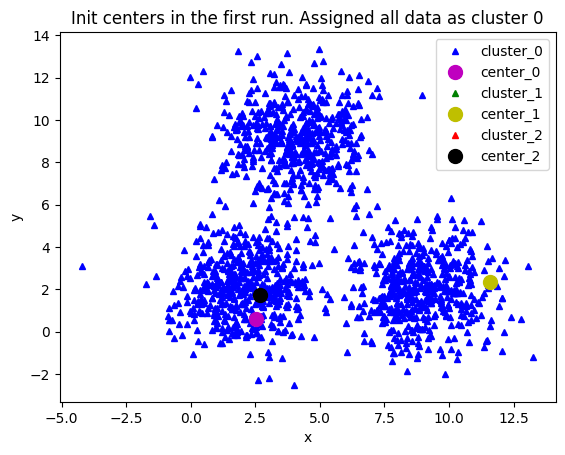

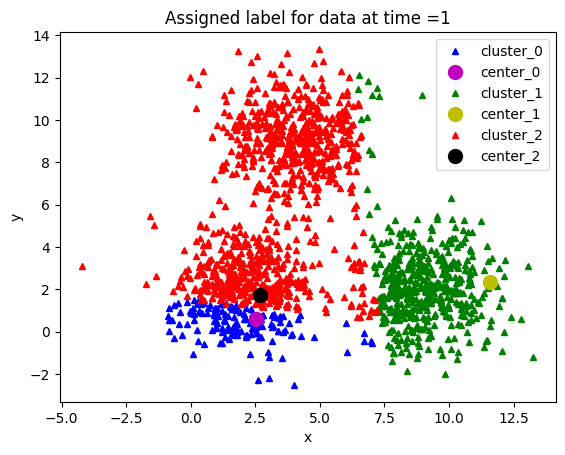

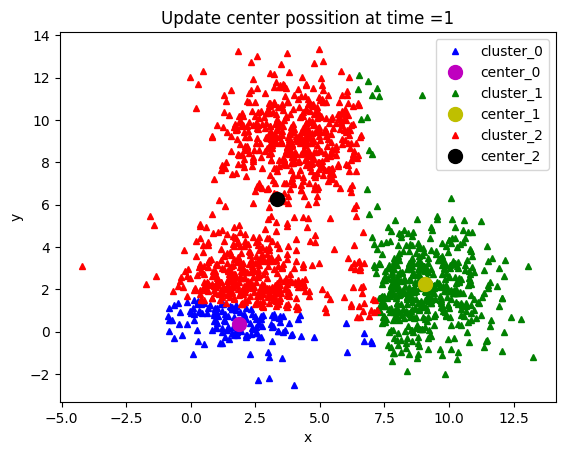

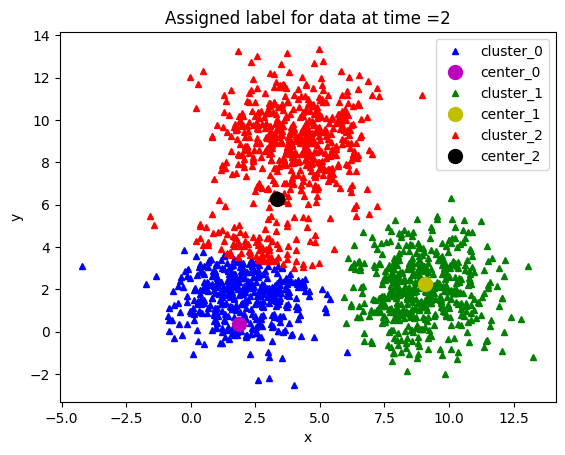

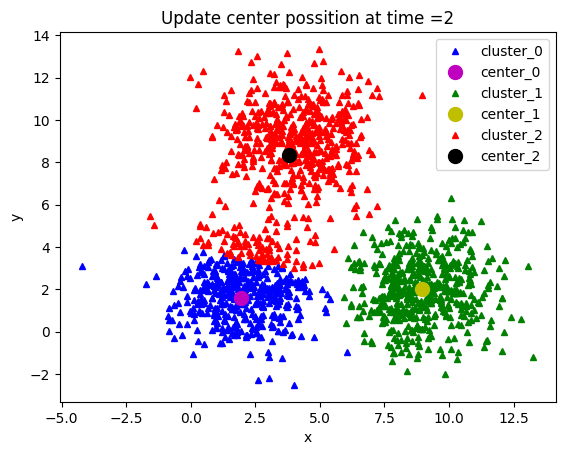

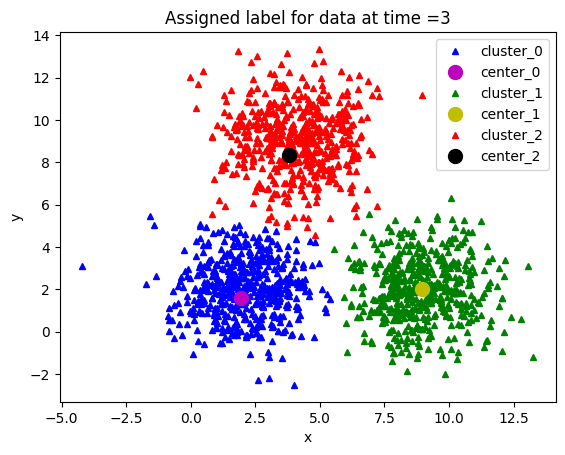

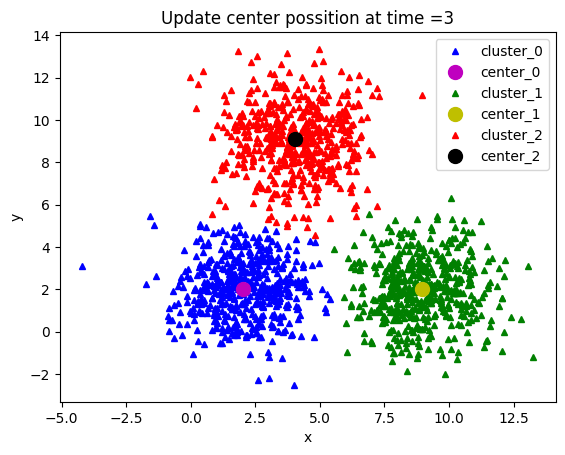

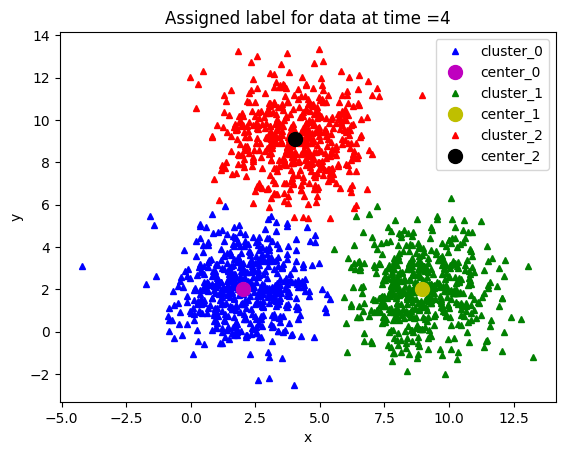

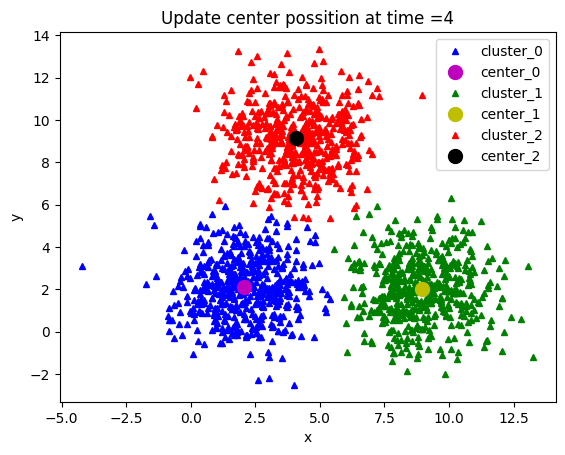

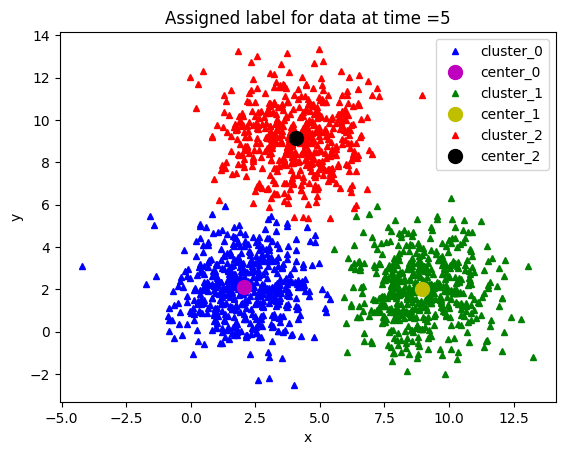

Done! Kmeans has converged after 4 times
[[2.04605966 2.08587263]
 [8.93627541 2.02441831]
 [4.05638929 9.17007252]]


In [13]:
# Khởi tạo các tâm cụm ban đầu bằng cách chọn ngẫu nhiên n_cluster điểm từ dữ liệu
init_centers = kmeans_init_centers(X, n_cluster)
print(init_centers) # In ra tọa độ khởi tạo ban đầu của các tâm cụm

# Khởi tạo nhãn ban đầu: tất cả các điểm được gán nhãn 0 (chưa phân cụm)
# np.zeros(X.shape[0]): tạo mảng có X.shape[0] phần tử, tất cả bằng 0
init_labels = np.zeros(X.shape[0])

# Hiển thị trạng thái ban đầu: các tâm cụm khởi tạo và tất cả điểm được gán vào cụm 0
kmeans_visualize(X, init_centers, init_labels, n_cluster,
"Init centers in the first run. Assigned all data as cluster 0")

# Chạy thuật toán K-means
# Hàm sẽ lặp lại cho đến khi các tâm cụm không thay đổi nữa
centers, labels, times = kmeans(init_centers, init_labels, X, n_cluster)

# In ra kết quả
print("Done! Kmeans has converged after", times ,"times")  # Số lần lặp cần thiết
print(centers)  # Tọa độ cuối cùng của các tâm cụm sau khi hội tụ